In [39]:
filename = 'eye_movements_1044'

import pandas as pd
df = pd.read_parquet('https://github.com/SAP-samples/portal/raw/refs/heads/main/data/fine_tune_data_50k_subsample'
                f'/classification/dirty/{filename}.parquet')

df.head()

,lineNo,assgNo,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,...,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,nWordsInTitle,titleNo,wordNo,label
0,1,1,1,1,1,0,0,100,100,99,...,0,0,0,0.0095,0.145,0.0131,7,4,3,0
1,2,1,1,1,1,0,99,278,278,159,...,0,0,0,0.0095,0.183,0.0363,7,1,1,0
2,3,1,1,1,1,0,278,159,159,159,...,0,0,0,0.0370,0.183,0.0208,7,1,3,0
3,4,1,1,1,1,0,159,159,159,139,...,0,0,0,0.0370,0.183,0.0208,7,1,5,0
4,5,1,1,1,1,0,159,139,139,239,...,0,0,0,0.0390,0.183,0.0182,7,1,6,0


In [11]:
len(df["label"].unique()) ## number of classes : 3

3

In [40]:
print(len(df.columns))

numerical_columns = []
for c in df.columns:
    if c != "label":
        try:
            df[c] = df[c].astype(float)
        except:
            print("proute")
        else:
            numerical_columns.append(c)
            
non_constant_columns = [c for c in numerical_columns if df[c].nunique() > 1]
df = df[non_constant_columns + ["label"]]

print(len(df.columns)) ### Still 28 columns because even the nominal columns are strings of floats 



28
28


ACP

In [48]:
from sklearn.decomposition import PCA
pca = PCA()
colonnes_x = [c for c in df.columns if c != 'label']

X = df[colonnes_x]
X = (X - X.mean()) / X.std()
cp = pca.fit_transform(X)
print(X.shape)
cp.shape


(10936, 27)


(10936, 27)

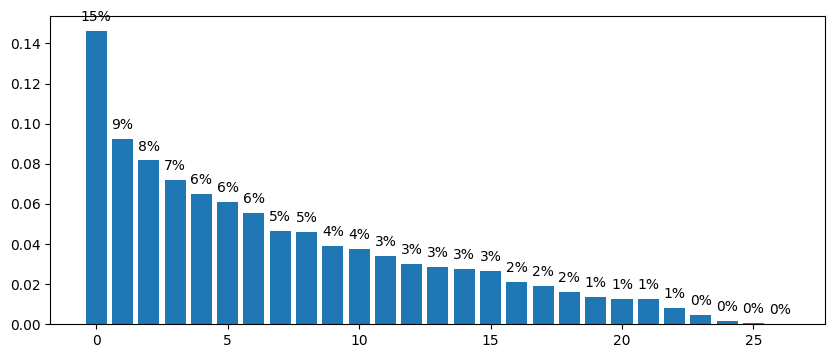

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))

plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
for i, var in enumerate(pca.explained_variance_ratio_):
    plt.text(i, var + 0.005, f'{var:.0%}', ha='center')

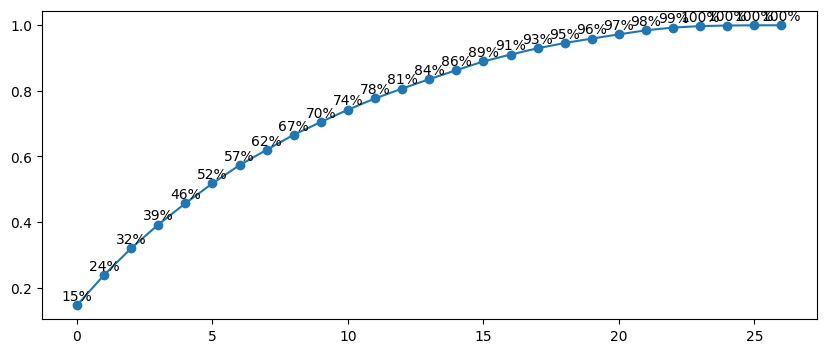

In [56]:
import numpy as np
In [25]: plt.figure(figsize=(10, 4))

plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
for i, var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i, var + 0.015, f'{var:.0%}', ha='center')

Non le premier plan n'explique que 39% de la variance totale, c'est mauvais.

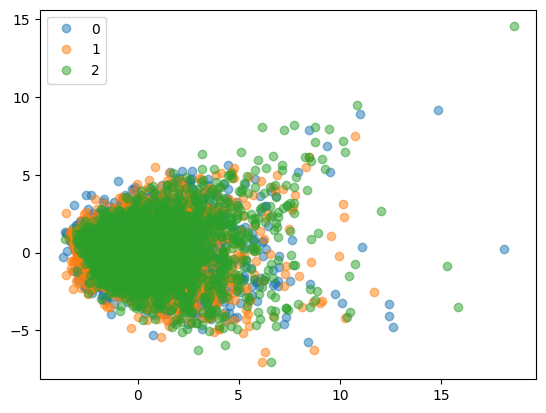

In [61]:
target = df['label']

plt.plot(cp[target == '0', 0], cp[target == '0', 1], 'o', label='0', alpha=0.5)
plt.plot(cp[target == '1', 0], cp[target == '1', 1], 'o', label='1', alpha=0.5)
plt.plot(cp[target == '2', 0], cp[target == '2', 1], 'o', label='2', alpha=0.5)
plt.legend()

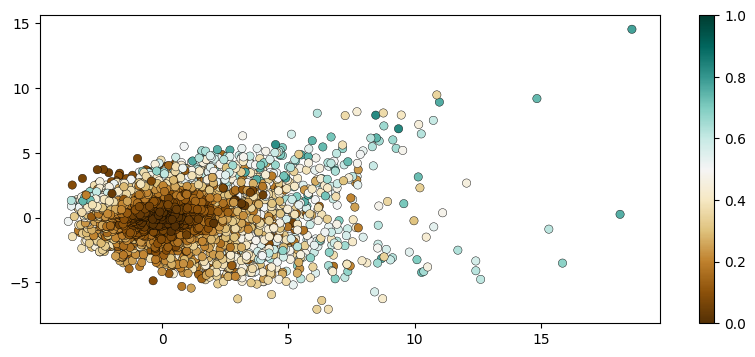

In [62]:
plt.figure(figsize=(10, 4))
numerateur = np.sum(cp[:, :2] ** 2, axis=1) # Y1**2 + Y2**2
normes2 = np.sum(cp ** 2, axis=1)
cosines2 = numerateur / normes2
plt.scatter(cp[:, 0], cp[:, 1], c=cosines2, cmap='BrBG', vmin=0, vmax=1, edgecolor='k', linewidth=0.3)
plt.colorbar()

(1, 2)
(27, 2)


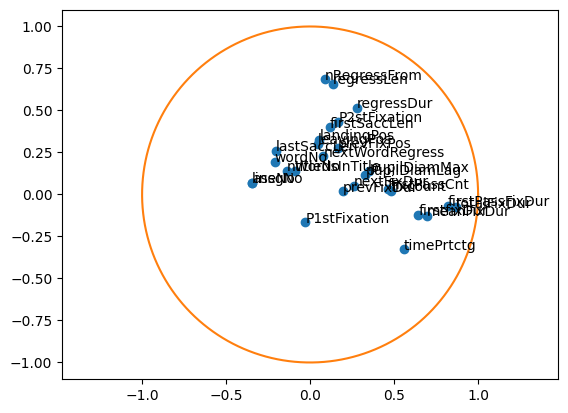

In [67]:
def cercle_correlation(axe1=0, axe2=1):
    racine_lambda_k = np.sqrt(pca.explained_variance_[None, [axe1, axe2]])
    print(racine_lambda_k.shape)
    u_kj = pca.components_[[axe1, axe2]].T
    print(u_kj.shape)
    corrs = racine_lambda_k * u_kj
    plt.plot(corrs[:, 0], corrs[:, 1], 'o')
    theta = np.linspace(0, 2*np.pi, 360)
    plt.plot(np.cos(theta), np.sin(theta))
    plt.gca().axis('equal')
    for name, (corr1, corr2) in zip(pca.feature_names_in_, corrs):
        # X.columns -> pca.feature_names_in_
        plt.text(corr1, corr2, name, fontsize=10)


cercle_correlation(0, 2)

(10936, 2)


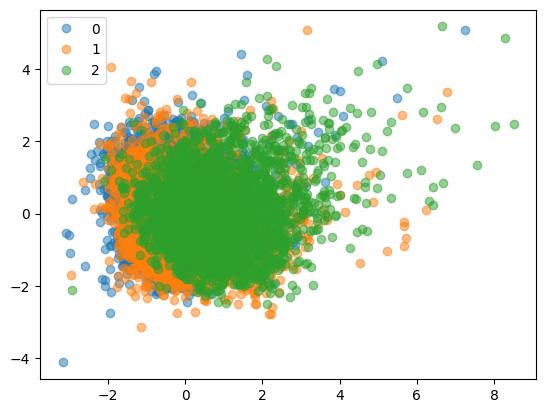

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
fd = lda.fit_transform(X, target)
print(fd.shape) ## on obtient 2 dimensions + justification ? 

plt.plot(fd[target == '0', 0], fd[target == '0', 1], 'o', label='0', alpha=0.5)
plt.plot(fd[target == '1', 0], fd[target == '1', 1], 'o', label='1', alpha=0.5)
plt.plot(fd[target == '2', 0], fd[target == '2', 1], 'o', label='2', alpha=0.5)
plt.legend()

In [71]:
preds = lda.predict(X)

accuracy = (preds == target).mean()
print(f'Accuracy : {accuracy:.1%}')

Accuracy : 51.1%


[[1743 1740  321]
 [1312 2383  567]
 [ 415  997 1458]]


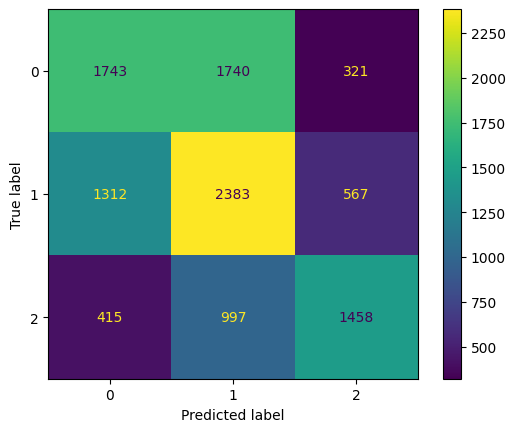

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(target, preds)
print(cm)

ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()

Le modèle n'est pas suffisant bon. Il se trompe une fois sur deux.